In [1]:
%matplotlib inline


import os, pathlib
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import pyaldata as pyal

if "__file__" not in dir():
    try:
        nbPath = pathlib.Path.cwd()
        RepoPath = nbPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        mouse_defs = params.mouse_defs
        defs = mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
        reload(dt)
        reload(defs)
        reload(params)
    finally:
        os.chdir(nbPath)
    
    # %run "S3-mouse-behaviour.ipynb"
    
    print('Done!')

FIGPATH = params.figPath / 'figS5-mouse-behavior'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done!


### Get data

In [2]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [3]:
allDFs_M1, allDFs_Str = get_full_mouse_data()

Executed: `get_full_mouse_data` in 0.9s


### Fig S6A: Mouse trajectories

In [4]:
import warnings

def plot_traj(ax, df):
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = params.colors.RightTrial
            label = 'right'
        elif df.target_id[i] in (1,):
            color = params.colors.LeftTrial
            label = 'left'
        
        ax.plot(traj[:,0], -traj[:,1], color=color, lw=.4, label=label)
        ax.plot(traj[0,0], -traj[0,1], color=color, marker='o', ms=2)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax.xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=3, nbins=3))
            ax.set_xticklabels(np.int16(ax.get_xticks()-ax.get_xticks().min()))
            ax.set_yticklabels(np.int16(ax.get_yticks()-ax.get_yticks().min()))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('$X (mm)$')
        ax.set_ylabel('$Y (mm)$')
        ax.set_title(df.mouse[0])

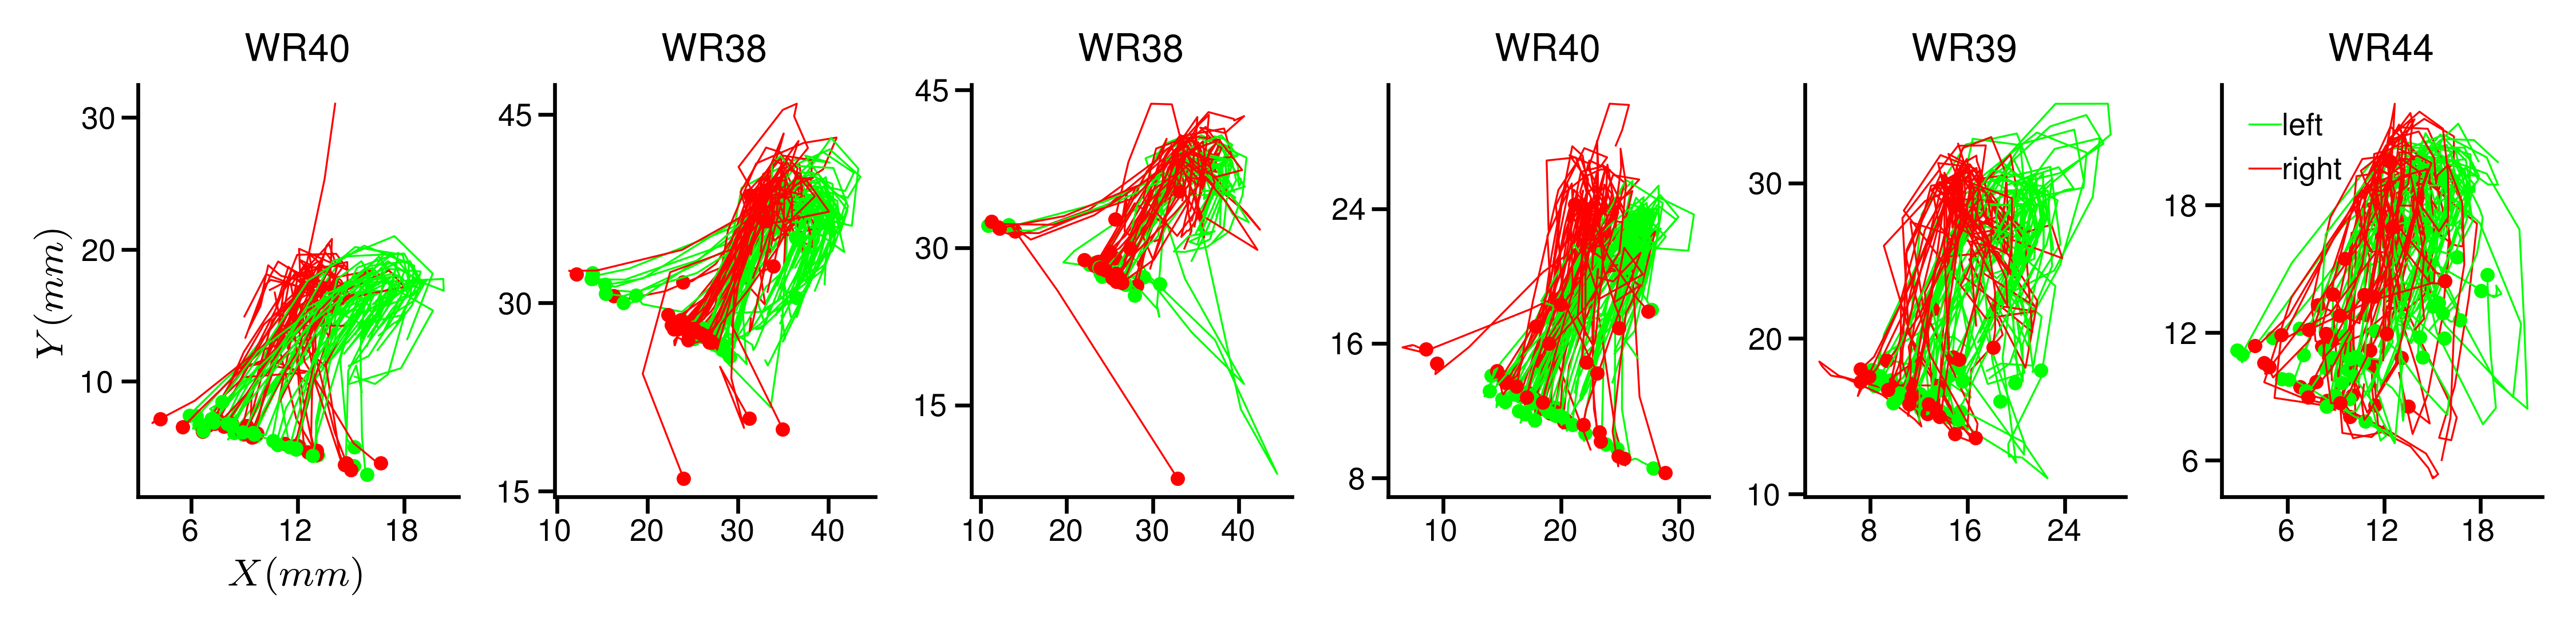

In [5]:
figsize=params.LargeFig
fig=plt.figure(figsize=figsize)

gs = utility.add_gridspec_abs(fig, nrows=1, ncols=len(allDFs_M1), left=0, 
                                width=figsize[0], 
                                height=params.panels.SmallH,
                                wspace=.3)

axes1=[]
for i, df in enumerate(allDFs_M1):
    axes1.append(ax:=fig.add_subplot(gs[i]))
    plot_traj(ax, df)
    if i>0:
        ax.set_ylabel('')
        ax.set_xlabel('')

ax.legend([ax.get_legend_handles_labels()[0][0],ax.get_legend_handles_labels()[0][25]],
            [ax.get_legend_handles_labels()[1][0],ax.get_legend_handles_labels()[1][25]],
            bbox_to_anchor=(0,1), loc=2, handletextpad=0.1, handlelength=1)

plt.savefig(FIGPATH / "mouse_traj.pdf", format= 'pdf', bbox_inches='tight')

### Fig S6B: Trajectory correlation within animal

In [6]:
try:
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-corr.ipynb"
finally:
    os.chdir(nbPath)

@utility.report
def plot_traj_corr(ax, AllDFs):

    within_corrs_mice = trim_within_mouse_corr (AllDFs)

    # plotting
    w_mice = list(within_corrs_mice.values())
    w_mice = np.array([l for L in w_mice for l in L])
    ax.hist(w_mice, density=True, alpha=.8, color=params.colors.MousePts)
    ax.axvline(w_mice.mean(), color=params.colors.MousePts, zorder=0)
    
    ax.set_yticks([])
    ax.set_xticks([0,1])
    ax.set_xlim([0,1])
    ax.set_ylabel('Probability\ndensity')
    ax.set_xlabel('Behavioural correlation')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('None')
    return within_corrs_mice


Executed: `plot_traj_corr` in 0.8s
Executed: `plot_traj_corr` in 1.4s
Executed: `plot_traj_corr` in 0.5s
Executed: `plot_traj_corr` in 1.5s
Executed: `plot_traj_corr` in 0.6s
Executed: `plot_traj_corr` in 0.8s


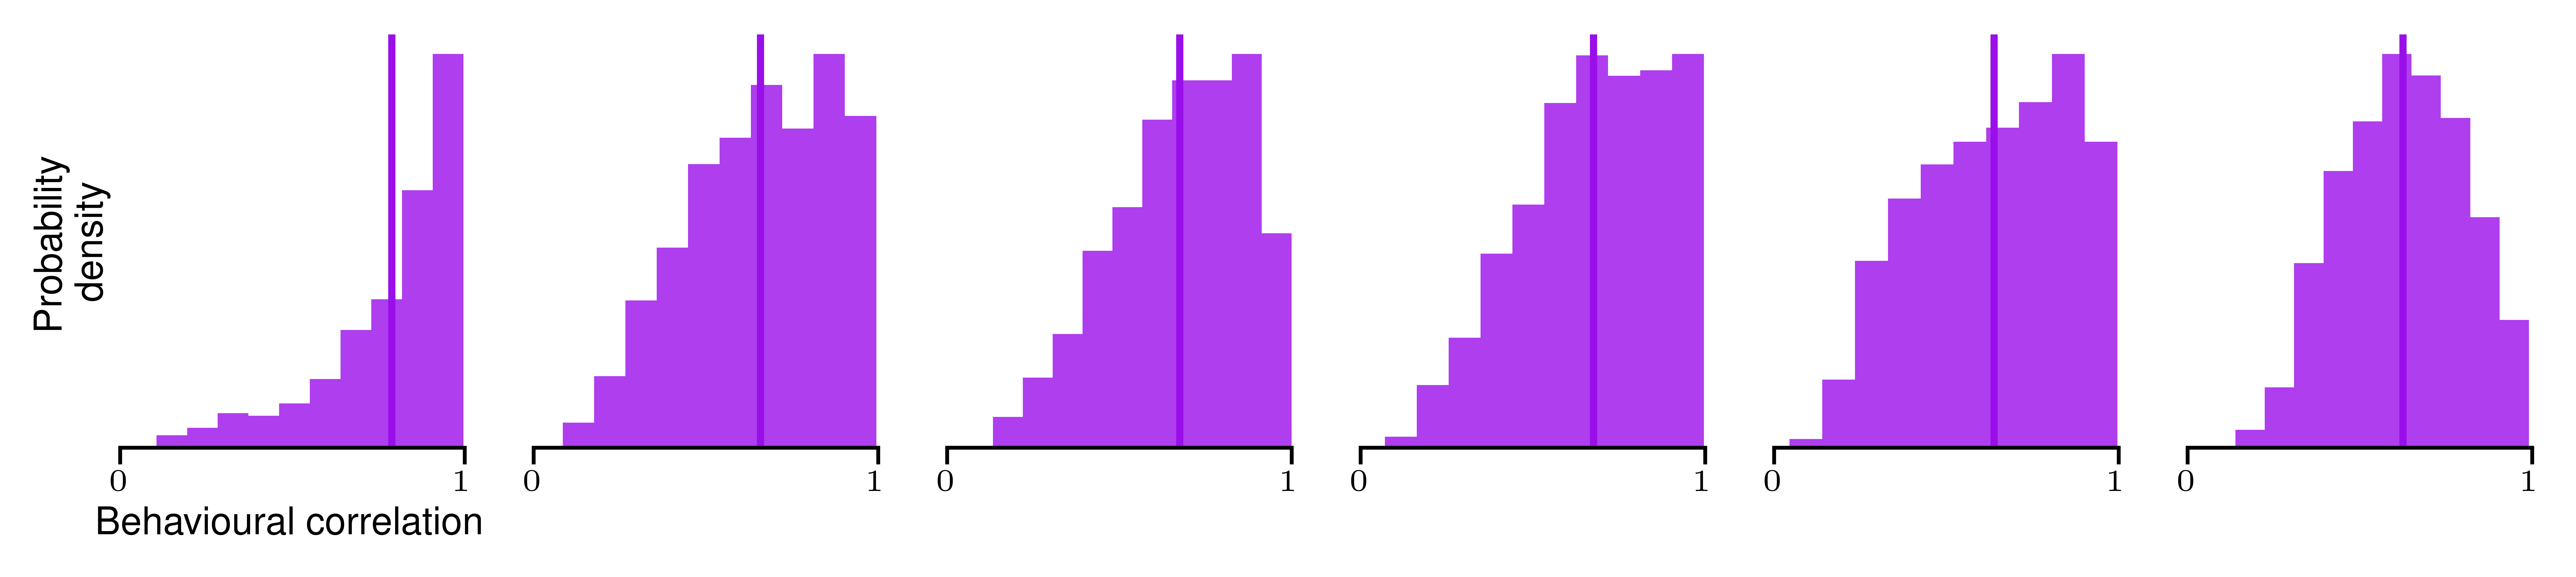

In [7]:
figsize=params.LargeFig
fig=plt.figure(figsize=figsize)

gs=utility.add_gridspec_abs(fig, nrows=1, ncols=len(allDFs_M1), left=0, 
                            width=figsize[0], 
                            height=params.panels.SmallH,
                            hspace=.1)

axes = []
for i, df in enumerate(allDFs_M1):
    axes.append(ax:=fig.add_subplot(gs[i]))
    plot_traj_corr(ax, [df])
    if i>0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
ax.legend()
plt.savefig(FIGPATH / "mouse-traj-corr.pdf", format= 'pdf', bbox_inches='tight')

### Fig S6C&D: Rasters and position

In [8]:
def get_example_mouse_data():
    example = defs._example
    animal = 'mouse-data'
    
    example_df = []
    for session in example:
        path = root / animal / session
        df = dt.load_pyal_data(path)
        path = str(path)
        df['mouse'] = path.split(os.sep)[-1][path.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = path.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
        example_df.append(df)
        
    return example_df

#### Fig S6C: MCx

In [9]:
raster_example = get_example_mouse_data()
raster_example_df = []
for df in raster_example:
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    df = pyal.remove_low_firing_neurons(df, 'M1_rates', 5, divide_by_bin_size=False)
    raster_example_df.append(df)

min_units = min([df.M1_rates[0].shape[1] for df in raster_example_df])
clear_output()

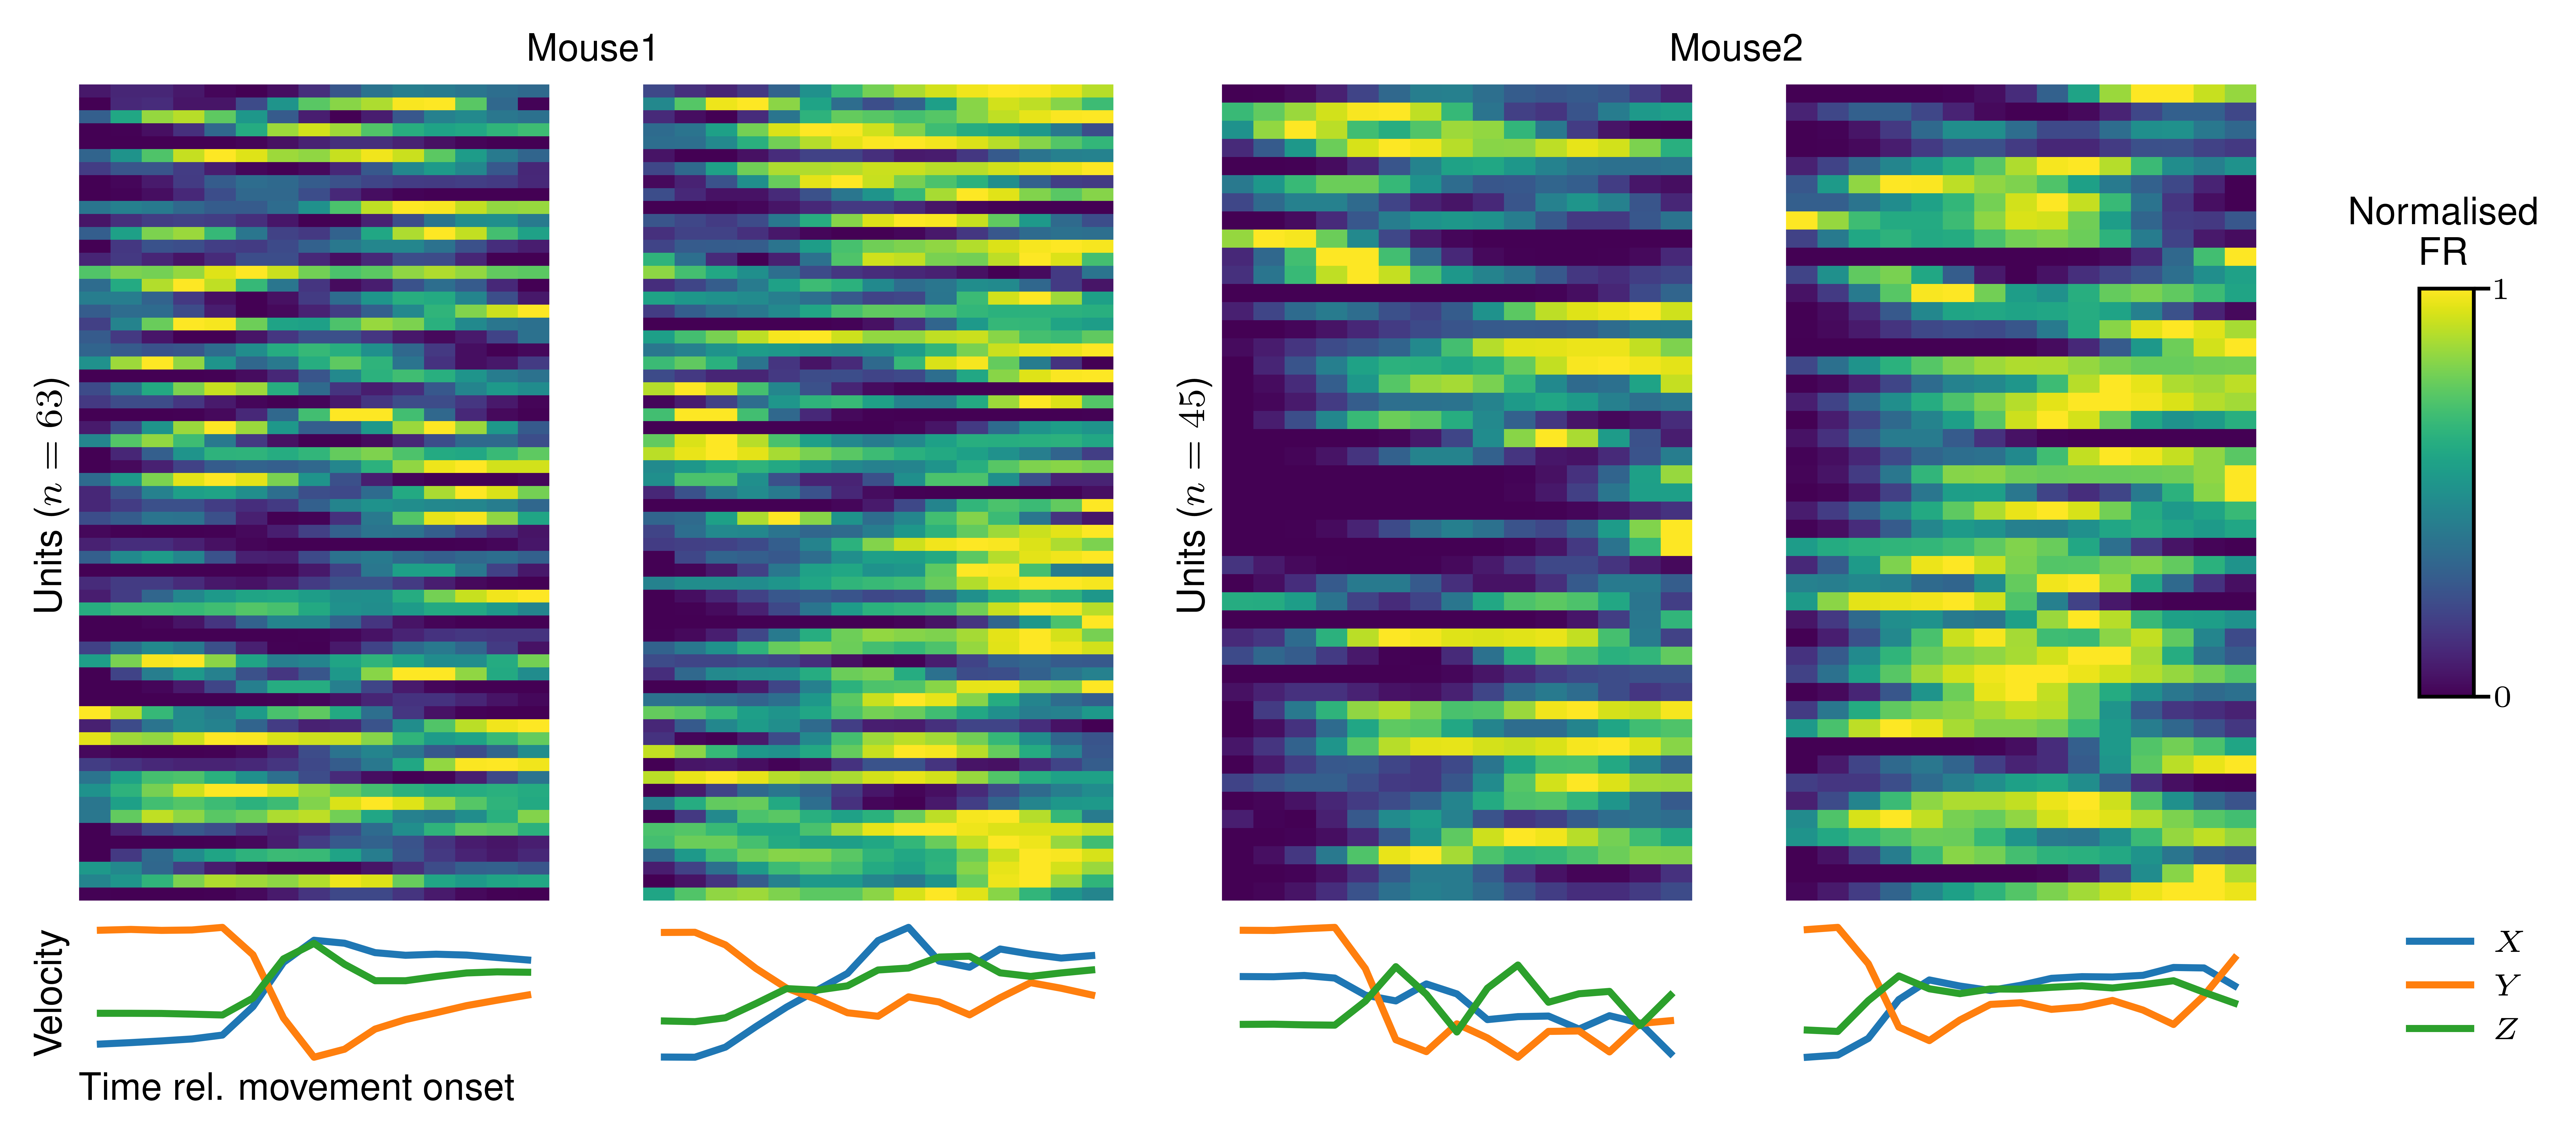

In [10]:
fig = plt.figure(figsize=(8,6))
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.4, right=.48, top=.8)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.4, right=.9, top=.8)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.96, bottom=0.5, right=.98, top=.7)
cax = fig.add_subplot(gs_c[:])

trial=0

for i,df in enumerate(raster_example_df):
    axes = []
    data = []
    min_units = np.inf
    for tar in range(2):
        df_ = pyal.select_trials(df, df.target_id==tar)
        df_ = df_.loc[[trial]]
        df_ = pyal.remove_low_firing_neurons(df_, 'M1_rates', 1)
        fr = df_.M1_rates[trial]
        data.append(fr)
        min_units = min([min_units, fr.shape[1]])
    data = np.array([tarData[:,:min_units] for tarData in data])
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))
    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[i][j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
cax.set_title('Normalised\nFR')
ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
ax.set_title('Mouse1')
ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
ax.set_title('Mouse2')

#========================
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.32, right=.48, top=.39)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.32, right=.9, top=.39)
gs = [gs1,gs2]

axes = []
for i,df in enumerate(raster_example_df):
    for tar in range(defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        while np.isnan(data := df_.hTrjB[trial]).sum()>0:
            trial +=1
        data -= np.mean(data,axis=0)
        ax = fig.add_subplot(gs[i][tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.plot(data[:,2], label='$Z$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel('Velocity')
axes[-1].legend(frameon=False, loc=(1.3,0.04))
axes[0].set_xlabel('Time rel. movement onset',loc='left')

fig.savefig(FIGPATH / 'mouse-FR-example-MCx.pdf', format='pdf', bbox_inches='tight')

#### Fig S6D: Str

In [11]:
raster_example = get_example_mouse_data()
raster_example_df = []
for df in raster_example:
    df = pyal.remove_low_firing_neurons(df, 'Str_rates', 1)
    raster_example_df.append(df)

clear_output()

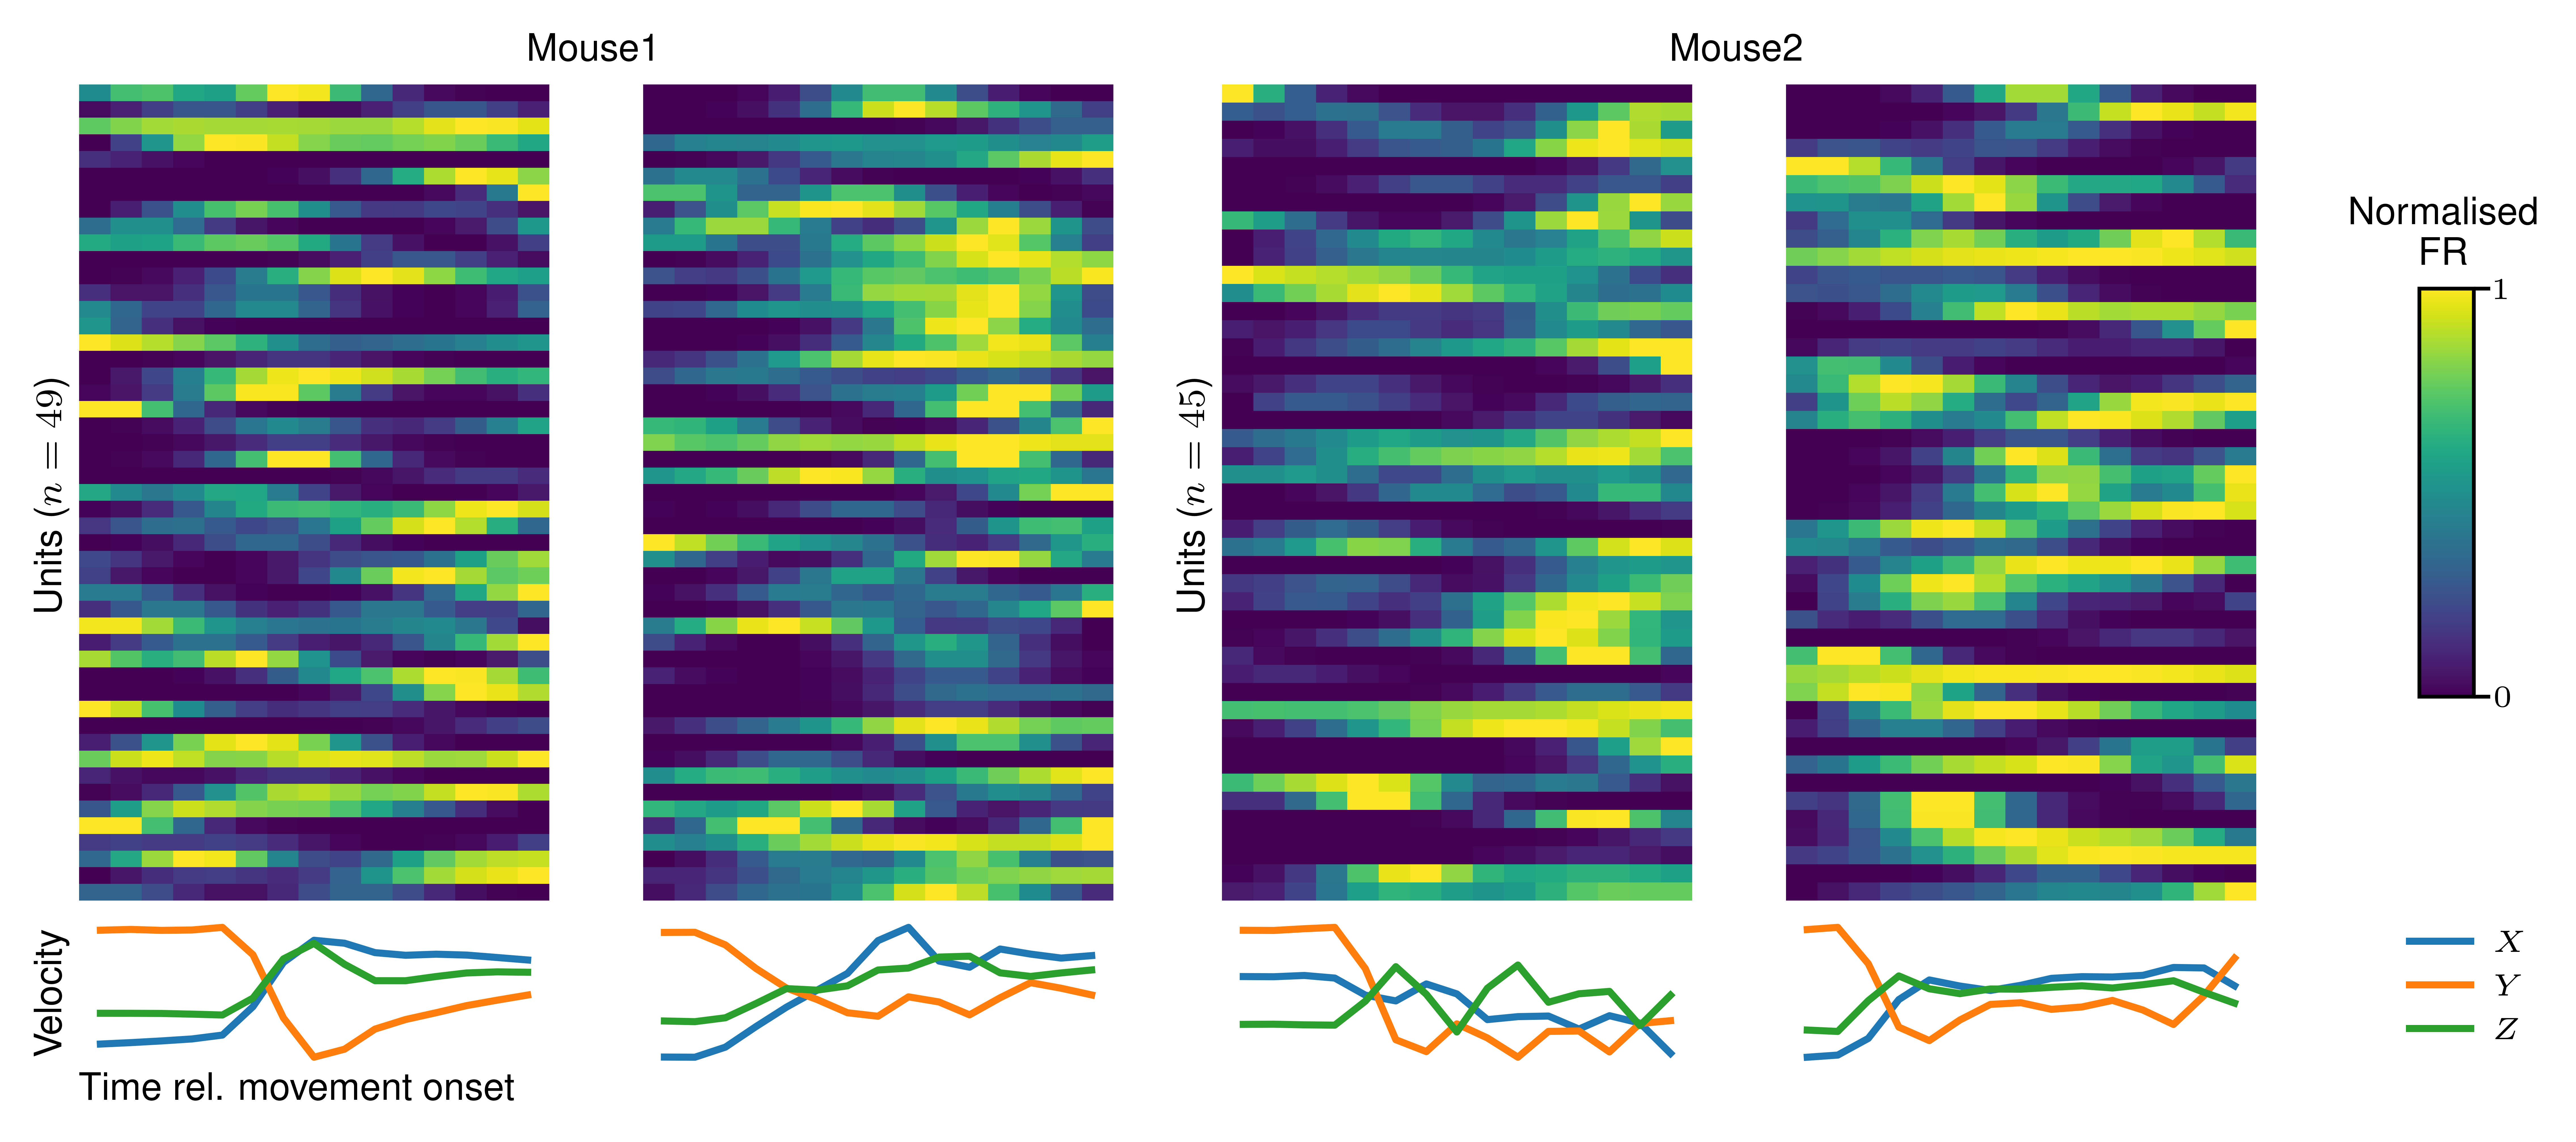

In [12]:
fig = plt.figure(figsize=(8,6))
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.4, right=.48, top=.8)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.4, right=.9, top=.8)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.96, bottom=0.5, right=.98, top=.7)
cax = fig.add_subplot(gs_c[:])

trial=0

for i,df in enumerate(raster_example_df):
    axes = []
    data = []
    min_units = np.inf
    for tar in range(2):
        df_ = pyal.select_trials(df, df.target_id==tar)
        df_ = df_.loc[[trial]]
        df_ = pyal.remove_low_firing_neurons(df_, 'Str_rates', 1)
        fr = df_.Str_rates[trial]
        data.append(fr)
        min_units = min([min_units, fr.shape[1]])
    
    data = np.array([tarData[:,:min_units] for tarData in data])
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))
    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[i][j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
cax.set_title('Normalised\nFR')
ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
ax.set_title('Mouse1')
ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
ax.set_title('Mouse2')

#========================
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.32, right=.48, top=.39)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.32, right=.9, top=.39)
gs = [gs1,gs2]

axes = []
for i,df in enumerate(raster_example_df):
    for tar in range(defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        while np.isnan(data := df_.hTrjB[trial]).sum()>0:
            trial +=1
        data -= np.mean(data,axis=0)
        ax = fig.add_subplot(gs[i][tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.plot(data[:,2], label='$Z$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel('Velocity')
axes[-1].legend(frameon=False, loc=(1.3,0.04))
axes[0].set_xlabel('Time rel. movement onset',loc='left')

fig.savefig(FIGPATH / 'mouse-FR-example-STR.pdf', format='pdf', bbox_inches='tight')

### Fig S6E: VAF distrbution

In [13]:
def plot_vaf(ax, df, field='M1_rates', **kwarg):
    n_components = 20
    
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    
    rates = np.concatenate(df_[field].values, axis=0)
    rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
    
    line = ax.plot(np.arange(1,n_components+1), np.cumsum(rates_model.explained_variance_ratio_),
                   label = 'M1' if 'M1' in field else 'Striatum', **kwarg)
    ax.set_yticks(np.arange(0,1,.2))
    ax.set_ylim([0,.9])
    ax.set_xticks(np.arange(1,n_components+1,3))
    ax.set_xlabel('Neural modes')
    ax.set_ylabel('VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return line

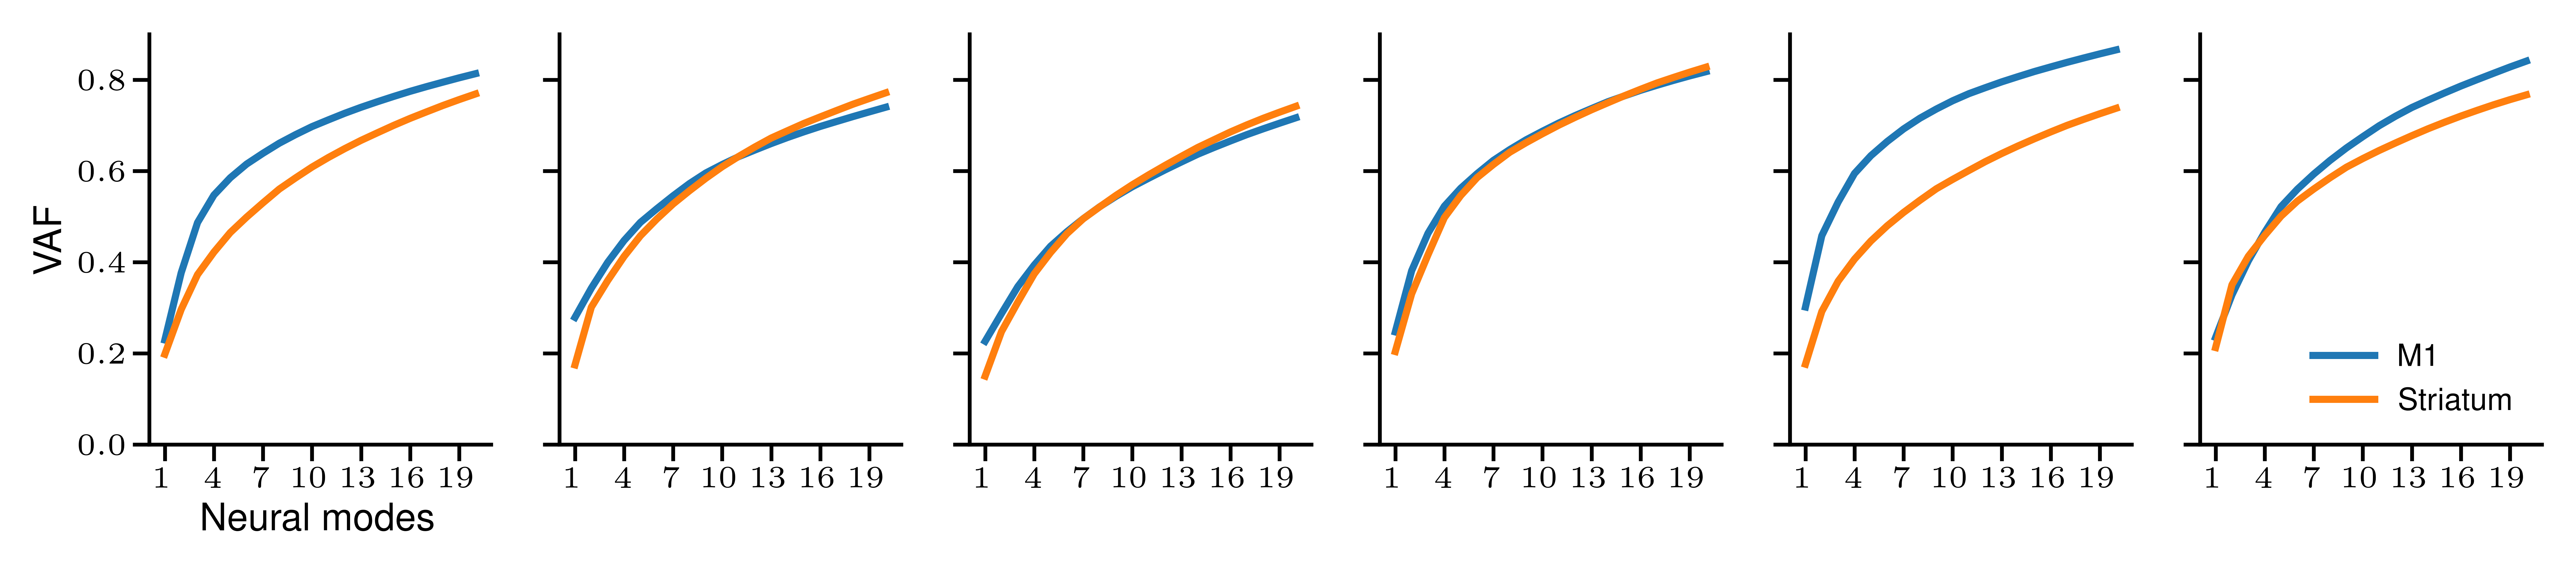

In [14]:
figsize=params.LargeFig
fig=plt.figure(figsize=figsize)

gs =utility.add_gridspec_abs(fig, nrows=1, ncols=len(allDFs_M1), left=0, 
                                    width=figsize[0], 
                                    height=params.panels.SmallH,
                                    hspace=.1)
    
axes=[]
# VAF(M1)
for i, df in enumerate(allDFs_M1):
    axes.append(ax:=fig.add_subplot(gs[i]))
    plot_vaf(ax, df, field = 'M1_rates', color=params.colors.MouseM1)
    ax.set_ylim([0,.9])
    if i>0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

# VAF(Str)
for i, (df,ax) in enumerate(zip(allDFs_M1, axes)):
    plot_vaf(ax, df, field = 'Str_rates', color=params.colors.MouseStr)
    if i>0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('')
    
ax.legend()

plt.savefig(FIGPATH / "mouse-VAF.pdf", format= 'pdf', bbox_inches='tight')